In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import norm

# ===== PARAMETERS =====
TIME_INTERVAL = '1h'  # Can be '5min', '15min', '1h', etc.
INTERVAL_MINUTES = 60     # Minutes corresponding to TIME_INTERVAL
VOLATILITY_WINDOW = 30    # Rolling window for volatility calculation
START_DATE = '2026-02-15'
# =====================

# BTC Up/Down Market Backtester

**Configuration Parameters** (edit cell 1 to change):
- Time Interval: `5min` (change to `15min`, `1h`, etc.)
- Volatility Window: `5` minutes
- Start Date: `2026-02-15`

Run all cells sequentially to perform the analysis.

In [160]:
btc_data = yf.download('BTC-USD', start=START_DATE, interval='1m', group_by='ticker')['BTC-USD']
btc_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Datetime,,,,,
2026-02-15 00:00:00+00:00,69758.539062,69758.539062,69758.539062,69758.539062,0
2026-02-15 00:02:00+00:00,69743.554688,69743.554688,69743.554688,69743.554688,0
2026-02-15 00:03:00+00:00,69756.320312,69756.320312,69756.320312,69756.320312,0
2026-02-15 00:04:00+00:00,69759.445312,69759.445312,69759.445312,69759.445312,0
2026-02-15 00:05:00+00:00,69773.484375,69773.484375,69773.484375,69773.484375,0


In [161]:
# Group by time interval and calculate start/end prices
btc_data['Start'] = btc_data.groupby(pd.Grouper(freq=TIME_INTERVAL))['Close'].transform('first')
btc_data['End'] = btc_data.groupby(pd.Grouper(freq=TIME_INTERVAL))['Close'].transform('last')

# Calculate time remaining in minutes until the next interval
btc_data['Time_Remaining'] = INTERVAL_MINUTES - (btc_data.index.minute % INTERVAL_MINUTES) - (btc_data.index.second / 60)

# Calculate log returns and volatility
btc_data['Log_returns'] = np.log(btc_data['Close'] / btc_data['Close'].shift(1)).dropna()
btc_data['Volatility'] = btc_data['Log_returns'].rolling(window=VOLATILITY_WINDOW).std() * np.sqrt(VOLATILITY_WINDOW)

# Drop NaN values
btc_data = btc_data.dropna()

# Exclude final minute of each interval (when time_remaining < 1) to avoid lookahead bias
btc_data = btc_data[btc_data['Time_Remaining'] > 1.0]

# Calculate distance from start price
btc_data['Distance'] = np.log(btc_data['Close'] / btc_data['Start'])

print(f"Time Interval: {TIME_INTERVAL}")
print(f"Data shape: {btc_data.shape}")
btc_data.head()

Time Interval: 1h
Data shape: (644, 11)


Price,Open,High,Low,Close,Volume,Start,End,Time_Remaining,Log_returns,Volatility,Distance
Datetime,,,,,,,,,,,
2026-02-15 00:33:00+00:00,69724.382812,69724.382812,69724.382812,69724.382812,15122432,69758.539062,69724.398438,27.0,0.000655,0.002027,-0.000490
2026-02-15 00:34:00+00:00,69718.898438,69718.898438,69718.898438,69718.898438,0,69758.539062,69724.398438,26.0,-0.000079,0.002018,-0.000568
2026-02-15 00:35:00+00:00,69713.765625,69713.765625,69713.765625,69713.765625,6631424,69758.539062,69724.398438,25.0,-0.000074,0.002008,-0.000642
2026-02-15 00:36:00+00:00,69658.125000,69658.125000,69658.125000,69658.125000,0,69758.539062,69724.398438,24.0,-0.000798,0.002152,-0.001440
2026-02-15 00:37:00+00:00,69647.335938,69647.335938,69647.335938,69647.335938,0,69758.539062,69724.398438,23.0,-0.000155,0.002139,-0.001595


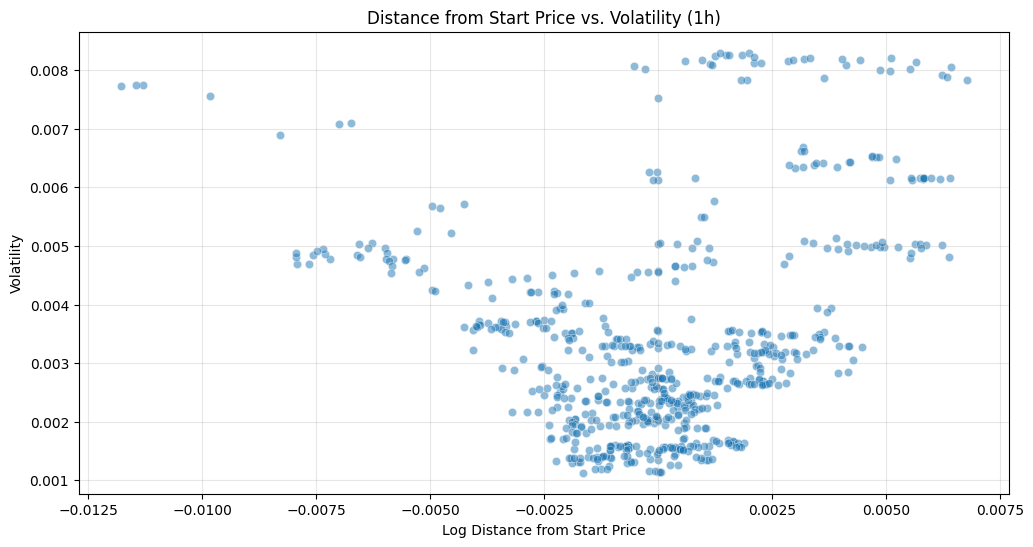

In [162]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Distance', y='Volatility', data=btc_data, alpha=0.5)
plt.title(f'Distance from Start Price vs. Volatility ({TIME_INTERVAL})')
plt.xlabel('Log Distance from Start Price')
plt.ylabel('Volatility')
plt.grid(True, alpha=0.3)
plt.show()

In [163]:
def calculate_model_prob(distance, volatility, time_remaining):
    """
    Calculate probability of UP movement using log-normal model
    
    Args:
        distance: log return from start price
        volatility: annualized volatility
        time_remaining: time remaining in minutes
    """
    # Normalize time remaining by interval minutes
    delta_t = time_remaining / INTERVAL_MINUTES
    denom = volatility * np.sqrt(delta_t)

    if denom == 0:
        return 0.5
    
    z = -distance / denom
    prob_up = 1 - norm.cdf(z)

    return prob_up

In [164]:
btc_data['Prob_Up'] = btc_data.apply(lambda row: calculate_model_prob(row['Distance'], row['Volatility'], row['Time_Remaining']), axis=1)

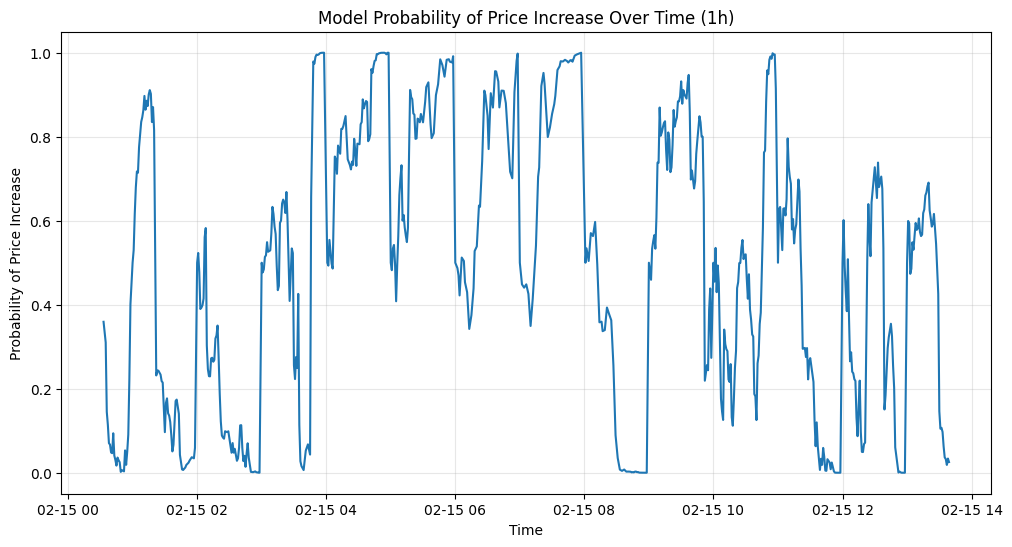

In [165]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=btc_data.index, y='Prob_Up', data=btc_data)
plt.title(f'Model Probability of Price Increase Over Time ({TIME_INTERVAL})')
plt.xlabel('Time')
plt.ylabel('Probability of Price Increase')
plt.grid(True, alpha=0.3)
plt.show()


Calibration Analysis (1h):
Price      Actual_Up       Prob_Up
                mean count    mean
Prob_Bin                          
(0.0, 0.2]     0.097   165   0.054
(0.2, 0.4]     0.278    90   0.292
(0.4, 0.6]     0.570   135   0.510
(0.6, 0.8]     0.467   105   0.701
(0.8, 1.0]     0.745   149   0.917


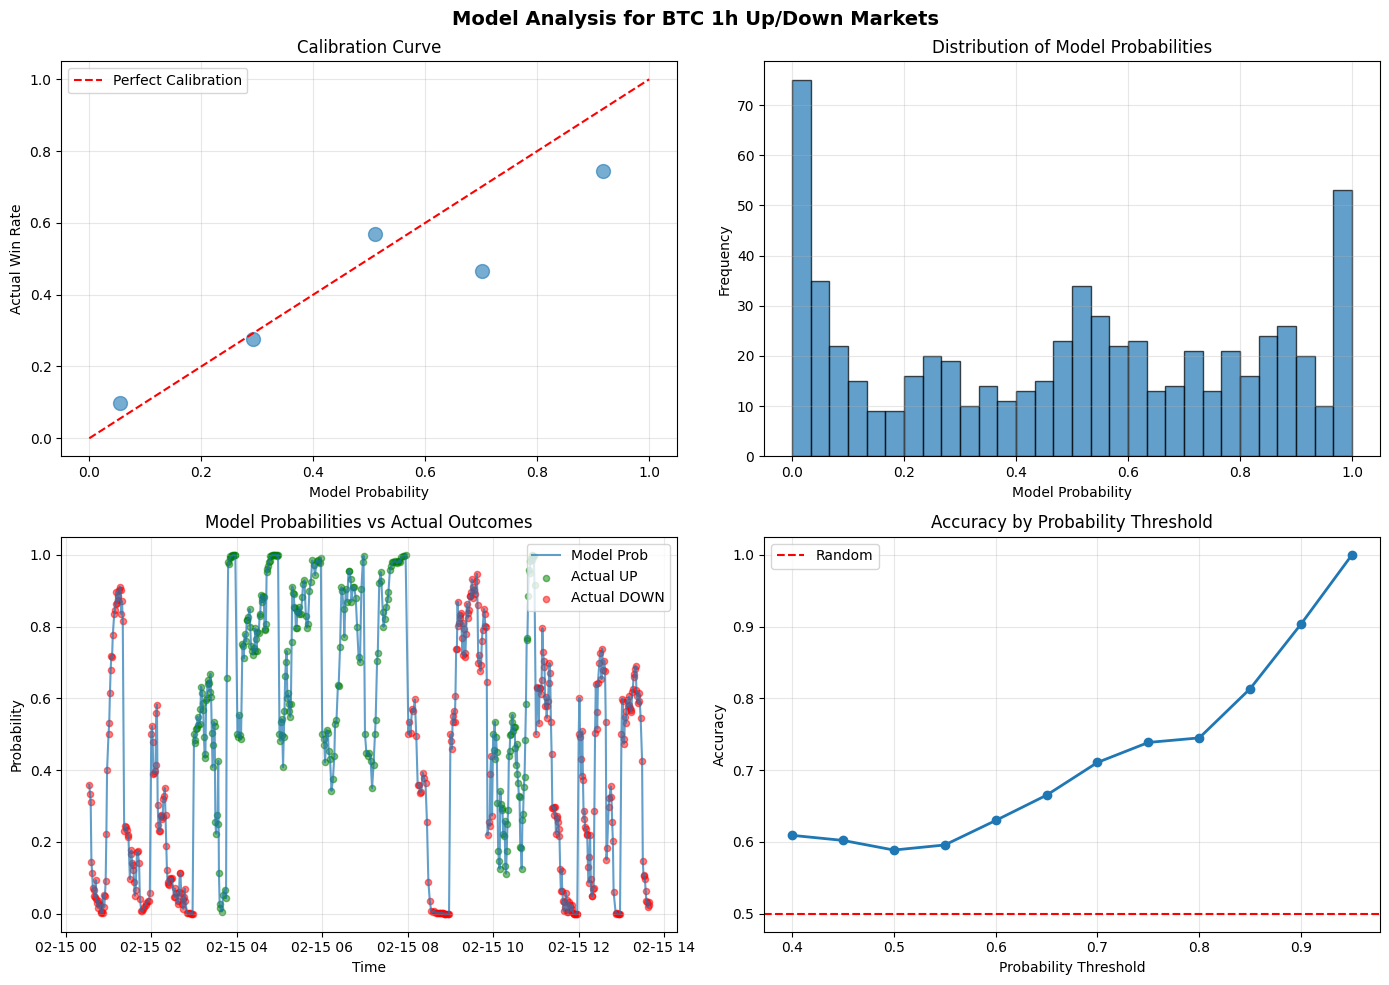


Model Statistics (1h):
Average Model Prob: 0.488
Actual UP Rate: 0.432
Overall Accuracy (>0.5 threshold): 0.663
Total samples: 644


In [166]:
# Create actual outcome column (1 = price went UP, 0 = price went DOWN)
# Based on the price at the END of the interval vs START
btc_data['Actual_Up'] = (btc_data['End'] > btc_data['Start']).astype(int)

# Create probability bins to compare calibration
btc_data['Prob_Bin'] = pd.cut(btc_data['Prob_Up'], bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

# Calculate actual win rate for each probability bin
calibration = btc_data.groupby('Prob_Bin', observed=True).agg({
    'Actual_Up': ['mean', 'count'],
    'Prob_Up': 'mean'
}).round(3)

print(f"\nCalibration Analysis ({TIME_INTERVAL}):")
print(calibration)

# Visualization: Model Calibration and Performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Model Analysis for BTC {TIME_INTERVAL} Up/Down Markets', fontsize=14, fontweight='bold')

# Plot 1: Calibration curve
ax1 = axes[0, 0]
prob_bins = btc_data.groupby('Prob_Bin', observed=True).agg({
    'Prob_Up': 'mean',
    'Actual_Up': 'mean'
}).reset_index(drop=True)

ax1.scatter(prob_bins['Prob_Up'], prob_bins['Actual_Up'], s=100, alpha=0.6)
ax1.plot([0, 1], [0, 1], 'r--', label='Perfect Calibration')
ax1.set_xlabel('Model Probability')
ax1.set_ylabel('Actual Win Rate')
ax1.set_title('Calibration Curve')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Model Probability Distribution
ax2 = axes[0, 1]
ax2.hist(btc_data['Prob_Up'], bins=30, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Model Probability')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Model Probabilities')
ax2.grid(True, alpha=0.3)

# Plot 3: Time series of probabilities vs outcome
ax3 = axes[1, 0]
ax3.plot(btc_data.index, btc_data['Prob_Up'], label='Model Prob', alpha=0.7)
ax3.scatter(btc_data[btc_data['Actual_Up']==1].index, 
           btc_data[btc_data['Actual_Up']==1]['Prob_Up'],
           color='green', label='Actual UP', alpha=0.5, s=20)
ax3.scatter(btc_data[btc_data['Actual_Up']==0].index,
           btc_data[btc_data['Actual_Up']==0]['Prob_Up'],
           color='red', label='Actual DOWN', alpha=0.5, s=20)
ax3.set_xlabel('Time')
ax3.set_ylabel('Probability')
ax3.set_title('Model Probabilities vs Actual Outcomes')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Accuracy by probability threshold
ax4 = axes[1, 1]
thresholds = np.arange(0.4, 1.0, 0.05)
accuracies = []
for threshold in thresholds:
    mask = btc_data['Prob_Up'] >= threshold
    if mask.sum() > 0:
        acc = btc_data[mask]['Actual_Up'].mean()
        accuracies.append(acc)
    else:
        accuracies.append(np.nan)

ax4.plot(thresholds, accuracies, marker='o', linewidth=2)
ax4.axhline(y=0.5, color='r', linestyle='--', label='Random')
ax4.set_xlabel('Probability Threshold')
ax4.set_ylabel('Accuracy')
ax4.set_title('Accuracy by Probability Threshold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nModel Statistics ({TIME_INTERVAL}):")
print(f"Average Model Prob: {btc_data['Prob_Up'].mean():.3f}")
print(f"Actual UP Rate: {btc_data['Actual_Up'].mean():.3f}")
print(f"Overall Accuracy (>0.5 threshold): {(btc_data['Prob_Up'] > 0.5).astype(int).eq(btc_data['Actual_Up']).mean():.3f}")
print(f"Total samples: {len(btc_data)}")